# Analyze of a trapped particle

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from numpy.random import *
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'
from scipy.optimize import curve_fit
plt.rcParams.update({'font.size': 16})

def autocorrFFT(x):
    N=len(x)
    F = np.fft.fft(x, n=2*N)  #2*N because of zero-padding
    PSD = F * F.conjugate()
    res = np.fft.ifft(PSD)
    res= (res[:N]).real   #now we have the autocorrelation in convention B
    n=N*np.ones(N)-np.arange(0,N) #divide res(m) by (N-m)
    return res/n #this is the autocorrelation in convention A

def msd_fft(r):
    N=len(r)
    D=np.square(r).sum(axis=1) 
    D=np.append(D,0) 
    S2=sum([autocorrFFT(r[:, i]) for i in range(r.shape[1])])
    Q=2*D.sum()
    S1=np.zeros(N)
    for m in range(N):
        Q=Q-D[m-1]-D[N-m]
        S1[m]=Q/(N-m)
    return S1-2*S2

def fitACF(x,tau):
    return ACFmean[0]*np.exp(-x/tau)

def chi2(ydata,Nparams,f, *params):
    res = ydata - f(*params)
    redchi2 = sum(res**2)/(len(ydata)-Nparams)
    return res, redchi2

def chi2abs(ydata,yErr,Nparams,f,*params):
    res = ydata - f(*params)
    redchi2 = sum((res/yErr)**2)/(len(ydata)-Nparams)
    return res, redchi2

In [4]:
dt = 100e-9       #frame rate 0.1 µs
datasets = 2      #how many datasets

Diameter = 2.19e-6     #parameters for analysis
R = Diameter/2
T = 273.15+20.9
kB = 1.38064852e-23
eta = 2.414e-5*10**(247.8/(T-140))
drag = 6*np.pi*eta*R
rho_p = 1040
rho_f = 998
V_p = 4.0/3*np.pi*R**3
M_p = rho_p*V_p
k = 1e-6
tau_p = M_p/(6*np.pi*eta*R)
tau_f = R**2*rho_f/eta
tau_k = 6*np.pi*eta*R/k
Diff_const=kB*T/drag
M_f = rho_f*V_p
M_eff = M_p + M_f/2
f_p=1/(2*np.pi*tau_p)
f_f=1/(2*np.pi*tau_f)
f_k=1/(2*np.pi*tau_k)

## Load the data from txt files

In [71]:
start_time = time.time()      #load datasets from txt-files
for i in range(datasets):
    xload = np.loadtxt('./Data/100ns/'+str(i)+'.txt')
    length = len(xload)
    if i == 0: x = np.zeros((length,datasets))
    x[:,i] = xload   
print("--- %s seconds ---" % round((time.time() - start_time),2)) 
timewave = np.linspace(0,length*dt,length,endpoint=False)
dtlength = timewave[-1]

--- 71.36 seconds ---


## Calculate the ACF (and estimate the error range)

In [6]:
start_time = time.time()             #calculate the ACF for every trajectory
ACF = np.zeros((length,datasets))
ACFmean = np.zeros(length)
for i in range(datasets):
    ACFcalc = autocorrFFT(x[:,i])
    ACF[:,i] = ACFcalc
    ACFmean += ACFcalc
ACFmean /= datasets

ACFerr = np.zeros(length)           #estimate the error of the ACF --- time consuming procedure!!!
#for i in range(length):             #comment out if not needed!
#    ACFerr[i] = np.std(ACF[i,:])/np.sqrt(datasets)
print("--- %s seconds ---" % round((time.time() - start_time),2))  

--- 153.63 seconds ---


## Plot the ACF and fit the expected function

1 V =  0.677  µm
tau_k =  0.958  +-  0.001 ms


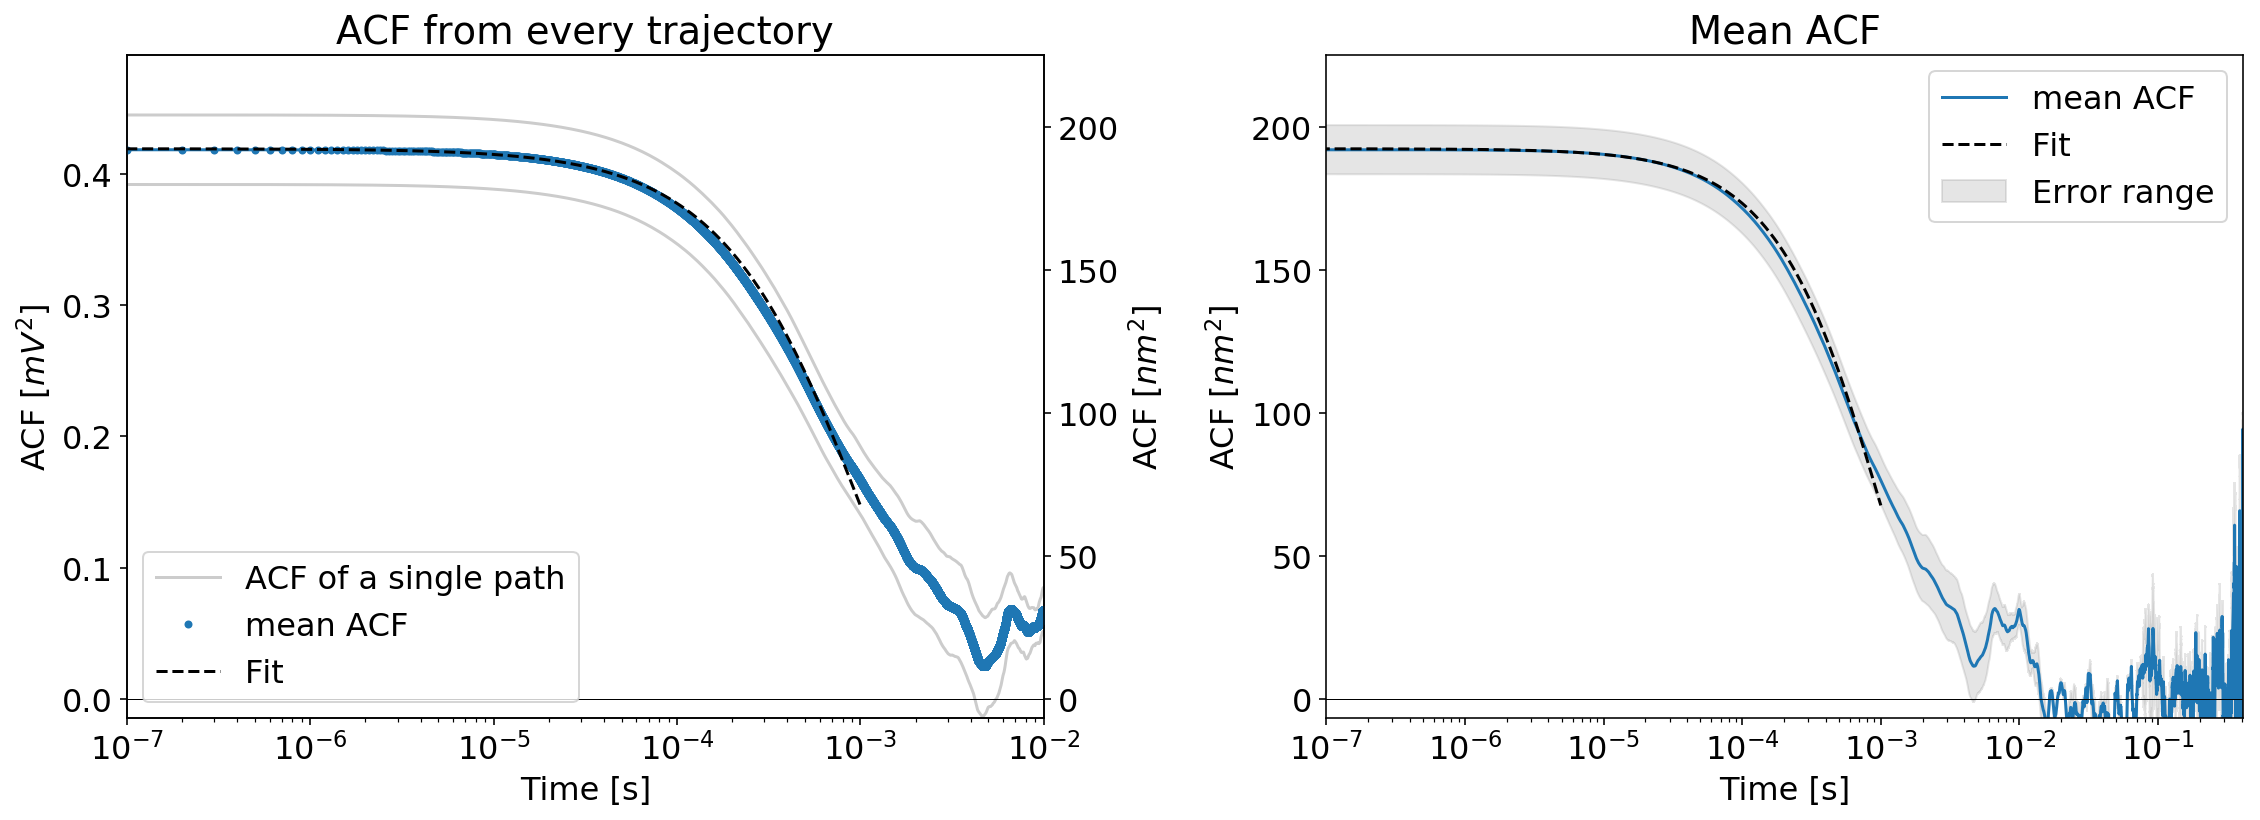

--- 55.21 seconds ---


In [63]:
start_time = time.time()
plottime = 0.01
plotlength = int(plottime/dt)
fittime = 0.001
fitlength = int(fittime/dt)

popt,pcov = curve_fit(fitACF, timewave[:fitlength], ACFmean[:fitlength],p0 = (0.001))
pErr = np.sqrt(np.diag(pcov))
r,redchi2 = chi2(ACFmean,1,fitACF,timewave,*popt)

taukACF = popt[0];taukACFerr = pErr[0]
Atheo = kB*T*taukACF/drag
Vtom = np.sqrt(Atheo/ACFmean[0])
print('1 V = ',round(Vtom*1e6,3),' µm')
print('tau_k = ',round(taukACF*1e3,3),' +- ',round(taukACFerr*1e3,3),'ms')
Conversiontonm = Vtom**2*1e18
ACFinnm = ACFmean*Conversiontonm

ACFmax = 1.1*ACF[:plotlength].max()
ACFmin = 1.1*ACF[:plotlength].min()

fig, ax1 = plt.subplots(figsize=(16,6))
ax = plt.subplot(121)
ax.set_xlabel('Time [s]')
ax.set_ylabel('ACF [$mV^{2}$]')
ax.tick_params(axis='y')
plt.semilogx(timewave[:plotlength],ACFmean[:plotlength]*1e3)
plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='-')
plt.ylim([ACFmin*1e3,ACFmax*1e3])
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
for i in range(datasets):
    if i == 0:
        plt.semilogx(timewave[:plotlength],ACF[:plotlength,i]*Conversiontonm,c='k',alpha=0.2,label = 'ACF of a single path')
    else:
        plt.semilogx(timewave[:plotlength],ACF[:plotlength,i]*Conversiontonm,c='k',alpha=0.2)
plt.semilogx(timewave[:plotlength],ACFinnm[:plotlength],'.',label='mean ACF')
plt.plot(timewave[:fitlength],fitACF(timewave[:fitlength],*popt)*Conversiontonm,'k--',label='Fit')
plt.xlim([dt,plottime])
plt.ylim([ACFmin*Conversiontonm,ACFmax*Conversiontonm])
ax2.set_ylabel('ACF [$nm^{2}$]')  # we already handled the x-label with ax1
ax2.tick_params(axis='y')
plt.title('ACF from every trajectory')
plt.legend()

plt.subplot(122)
plt.semilogx(timewave, ACFinnm,label = 'mean ACF')
plt.fill_between(timewave, ACFinnm - ACFerr*Conversiontonm, 
                 ACFinnm + ACFerr*Conversiontonm,
                 color='gray', alpha=0.2, label = 'Error range')
plt.plot(timewave[:fitlength],fitACF(timewave[:fitlength],*popt)*Conversiontonm,'k--',label='Fit')
plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='-')
plt.xlabel('Time [s]')
plt.ylabel('ACF [$nm^{2}$]')
plt.xlim([dt,dtlength])
plt.ylim([ACFmin*Conversiontonm,ACFmax*Conversiontonm])
plt.title('Mean ACF')
plt.legend()
plt.tight_layout()  
plt.savefig('ACF.pdf', format='pdf')
plt.show()
print("--- %s seconds ---" % round((time.time() - start_time),2))  

## Determine the timepoints for reducing the data

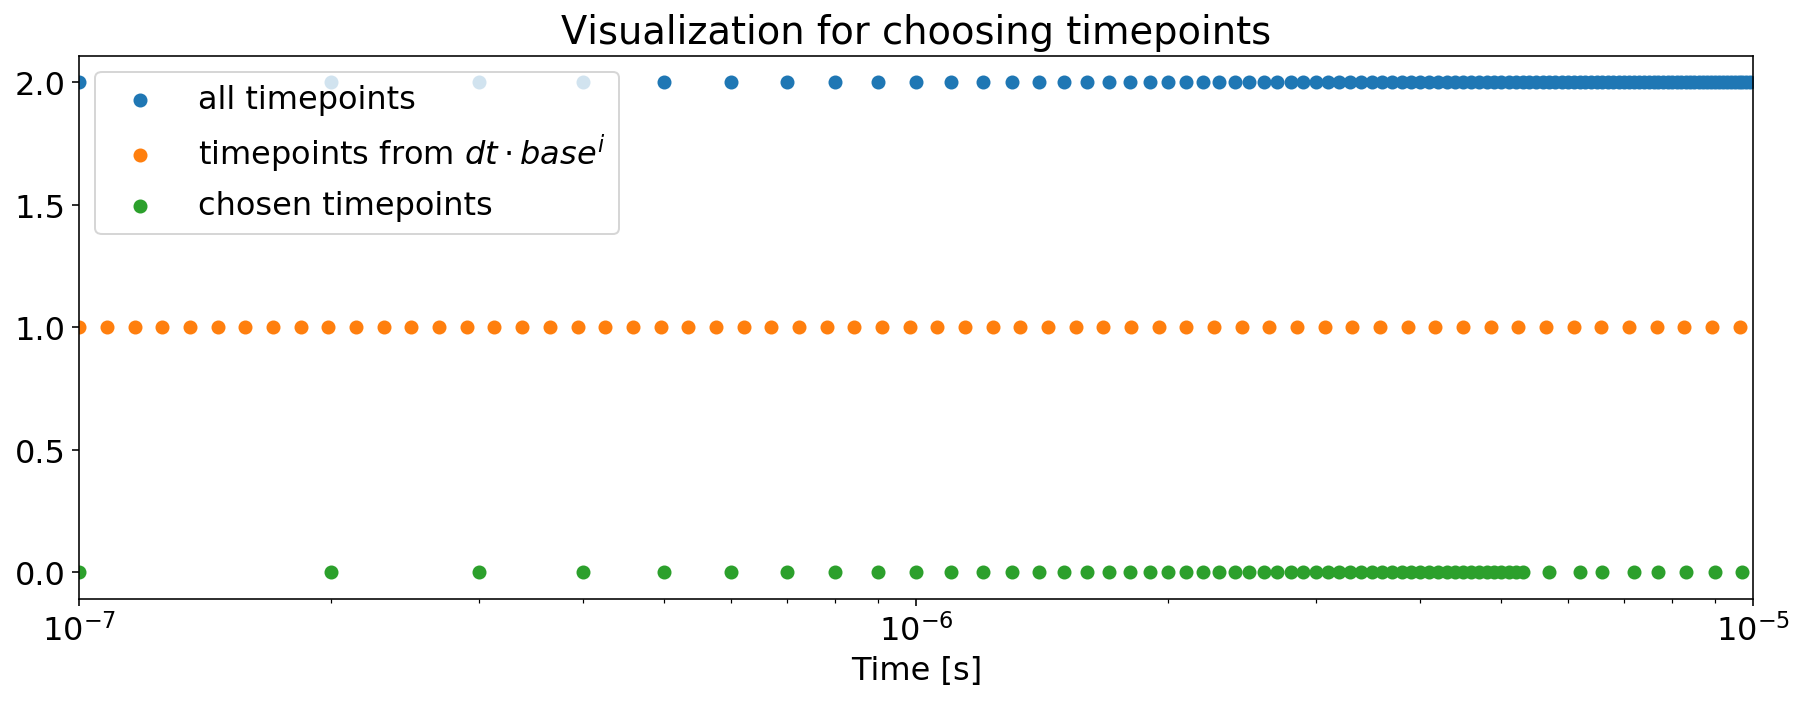

In [68]:
newlength = 200
base = (dtlength/dt)**(1/newlength)
newtimewave = np.zeros(newlength)
for i in range(newlength):
    newtimewave[i] = dt*base**i

savedata = np.zeros((newlength,4))
count = 0
for i in range(newlength):
    found = False
    while found == False:
        if timewave[count] >= newtimewave[i]:
            savedata[i,0] = timewave[count]
            savedata[i,1] = ACFinnm[count]
            savedata[i,2] = ACFerr[count]*Conversiontonm
            savedata[i,3] = fitACF(timewave[count],*popt)*Conversiontonm         
            found = True
        count +=1

limit = 100*dt
fig = plt.figure(1, figsize = (15,5))
ax = plt.gca()
ax.scatter(timewave[:int(limit/dt)],2*np.ones(int(limit/dt)),label = 'all timepoints')
ax.scatter(newtimewave,1*np.ones(newlength),label =r'timepoints from $dt \cdot base^{i}$ ')
ax.scatter(savedata[:,0],np.zeros(newlength),label = 'chosen timepoints')
ax.set_xscale('log')
ax.set_xlim([dt,limit])
ax.set_xlabel('Time [s]')
plt.title('Visualization for choosing timepoints')
plt.legend()
plt.show()

# Plotting the reduced data

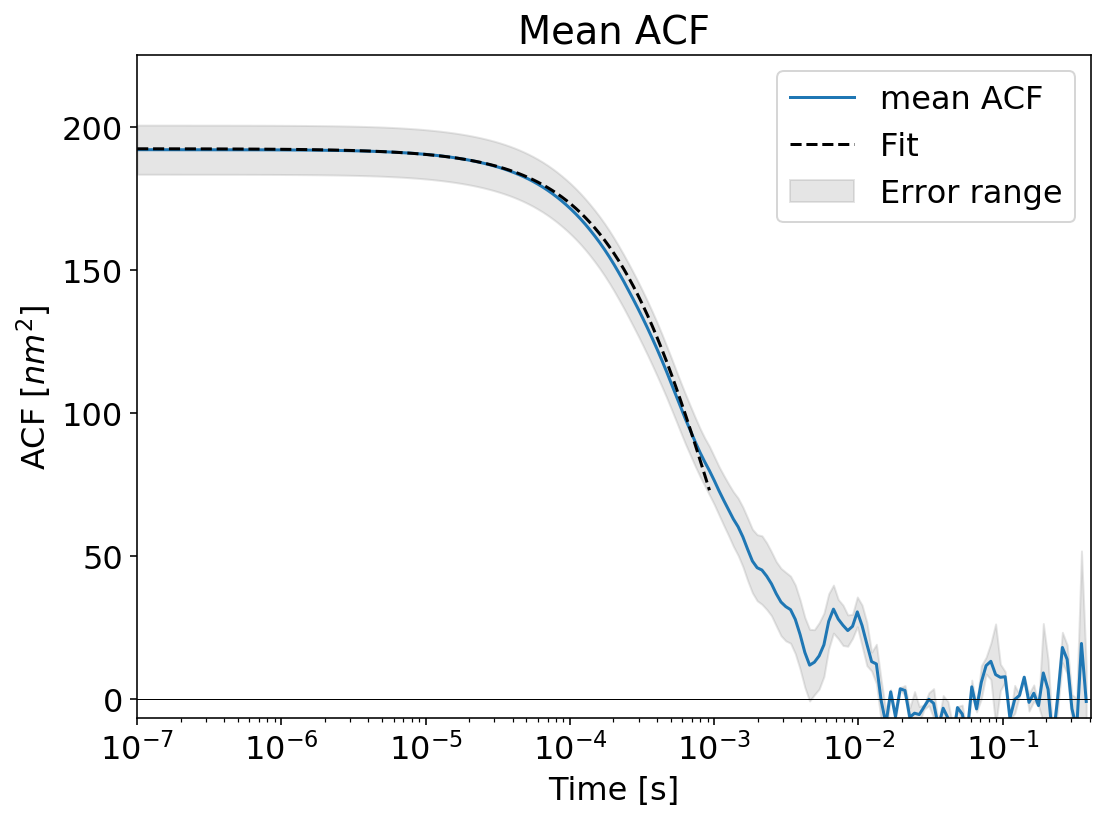

In [69]:
count = 0; check = False
while check == False:
    if savedata[count,0] >= fittime:
        check = True
        fittime2 = savedata[count,0]
        fitlength2 = count
    else: count += 1

fig, ax1 = plt.subplots(figsize=(8,6))
plt.subplot(111)
plt.semilogx(savedata[:,0], savedata[:,1],label = 'mean ACF')
plt.fill_between(savedata[:,0], savedata[:,1] - savedata[:,2], 
                 savedata[:,1] + savedata[:,2],
                 color='gray', alpha=0.2, label = 'Error range')
plt.plot(savedata[:fitlength2,0],savedata[:fitlength2,3],'k--',label='Fit')
plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='-')
plt.xlabel('Time [s]')
plt.ylabel('ACF [$nm^{2}$]')
plt.xlim([dt,dtlength])
plt.ylim([ACFmin*Conversiontonm,ACFmax*Conversiontonm])
plt.title('Mean ACF')
plt.legend()
plt.tight_layout()  
plt.savefig('ACF.pdf', format='pdf')
plt.show()

## Save the reduced data

In [70]:
np.savetxt('DataACF.txt', np.transpose([savedata[:,0],savedata[:,1],savedata[:,2],savedata[:,3]]),fmt='%1.6f')